In this notebook, we will try to build machine learning model that provides prediction for potential flight claims by delay/cancel.

In [1]:
# Import libraries
import pandas as pd, numpy as np, time
import lightgbm as lgb

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
def print_metrics(to_check_y, to_check_pred):
    # We check the score of set result in two ways
    # Confusion matrix
    cm = confusion_matrix(to_check_y, to_check_pred)
    # Accuracy
    accuracy=accuracy_score(to_check_pred,to_check_y)
    
    print(cm)
    print("Accuracy:", accuracy)
    print("Delay/Cancel case accuracy:", cm[1][1] / sum(cm[1]))
    
    return cm, accuracy

# Naive approach

For the most straightforward approach, only the per-record features are used for the prediction. In this case, it consists of a mixture of categorical and numerical values.

The prediction is supposed to be a regression problem, as to predict expected monetary claim of all flights. Previous study shows that there are only two is_claim values, thus the model training would be treated as classification problem first (making accuracy measurement easier).

In [76]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data.csv')

# Check data columns
data_df.columns

Index(['flight_id', 'flight_no', 'Week', 'Departure', 'Arrival', 'Airline',
       'std_hour', 'delay_time', 'flight_date', 'is_claim'],
      dtype='object')

We first modify the columns for model training:

In [77]:
# Transform categorical features to numerical labels such that the ML model can utilize those features properly
cat_feats = ['flight_no', 'Week', 'Departure','Arrival','Airline','std_hour']
for cat_col in cat_feats:
    data_df[cat_col] = data_df[cat_col].astype("category").cat.codes + 1

In [78]:
# For target is_claim, since we know there are only two values, the plan is to transform it into boolean variable
# It is easier for measuring accuracy in this way. In the actual model, we can ignore this part and do regression on is_claim amount instead.
def set_is_claim(val):
    if val == 0:
        return 0
    else:
        return 1
data_df['is_claim_bool'] = data_df["is_claim"].apply(set_is_claim)

In [79]:
# Check transformed result
data_df.sample(10)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,is_claim_bool
764123,2373852,425,38,1,21,27,17,0.2,2014-09-23,0,0
59911,185534,469,37,1,135,28,24,0.6,2015-09-14,0,0
300587,934842,974,8,1,62,31,13,0.4,2016-02-25,0,0
383734,1193876,2123,22,1,129,108,21,0.6,2015-06-02,0,0
141943,440196,704,21,1,25,28,14,0.3,2015-05-22,0,0
592956,1844359,1733,36,1,37,68,14,0.4,2015-09-07,0,0
860554,2673517,219,42,1,129,16,17,0.4,2014-10-21,0,0
383998,1194729,729,28,1,138,28,11,-0.1,2014-07-15,0,0
761317,2365028,2084,36,1,65,102,24,0.0,2014-09-04,0,0
236043,733997,1893,3,1,11,80,9,0.5,2016-01-17,0,0


In [80]:
# Get x/y columns
x_all = data_df[cat_feats]
y_all = data_df['is_claim_bool']

# Split training/testing set
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

There are several machine learning models that can tackle this problem. It is decided to use ensemble method (i.e. GBDT in particular) as it is relatively easier to tune for (in contrast to something like NN models that requires tuning network structure), and the underlying decision tree makes it easier to interpret for feature importance.

In [81]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
lg = lgb.LGBMClassifier(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

# Train model with catgeorical features
model = lgb.train(params, d_train, categorical_feature = cat_feats)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [82]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

[[600414   1604]
 [ 20202   7159]]
Accuracy: 0.965353149691998
Delay/Cancel case accuracy: 0.2616497935016995


(array([[600414,   1604],
        [ 20202,   7159]], dtype=int64), 0.965353149691998)

In [83]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = model.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

[[256214   1469]
 [  9879   2173]]
Accuracy: 0.9579290785400486
Delay/Cancel case accuracy: 0.18030202456023897


(array([[256214,   1469],
        [  9879,   2173]], dtype=int64), 0.9579290785400486)

Although the model shows a 95% accuracy, the confusion matrix shows that there are 3274 cases of actual needed-to-be-claimed flights, but mis-classified as normal flights. The correct classified ratio of delay/cancel flights in this case would be 553 / (3274 + 553) ~= 14%.

In [84]:
# ['Week', 'Departure','Arrival','Airline','std_hour']
print("Per split importance: ", model.feature_importance(importance_type='split'))
print("Per gain importance: ", model.feature_importance(importance_type='gain'))

Per split importance:  [82665 93331     0 25679 11933 56092]
Per gain importance:  [22343.0273997  12597.24884576     0.          6185.19991738
  1402.88932863  6690.27051868]


# Feature engineering approach

In [3]:
# Load the dataset
data_df = pd.read_csv('../datasets/flight_delays_data_transformed.csv')

# Check data size
data_df.columns

Index(['Unnamed: 0', 'flight_id', 'flight_no', 'Week', 'Departure', 'Arrival',
       'Airline', 'std_hour', 'delay_time', 'flight_date', 'is_claim',
       'flight_date_dt', 'flight_dt', 'flight_year', 'flight_month',
       'flight_day', 'flight_2_hour_bin', 'flight_4_hour_bin', 'flight_ts',
       'flight_2_hour_ts', 'flight_4_hour_ts', 'flight_day_ts', 'flight_wk_ts',
       'dep_hr_delay_time', 'dep_2_hr_delay_time', 'dep_4_hr_delay_time',
       'dep_day_delay_time', 'dep_wk_delay_time', 'arr_hr_delay_time',
       'arr_2_hr_delay_time', 'arr_4_hr_delay_time', 'arr_day_delay_time',
       'arr_wk_delay_time', 'air_hr_delay_time', 'air_2_hr_delay_time',
       'air_4_hr_delay_time', 'air_day_delay_time', 'air_wk_delay_time',
       'arr_air_hr_delay_time', 'arr_air_2_hr_delay_time',
       'arr_air_4_hr_delay_time', 'arr_air_day_delay_time',
       'arr_air_wk_delay_time', 'dep_hr_delay_count', 'dep_2_hr_delay_count',
       'dep_4_hr_delay_count', 'dep_day_delay_count', 'dep_wk_d

In [5]:
# Transform categorical features to numerical labels such that the ML model can utilize those features properly
all_feats = ['flight_no', 'Week', 'Departure','Arrival','Airline','std_hour', 
           'dep_hr_delay_time', 'dep_2_hr_delay_time', 'dep_4_hr_delay_time',
           'dep_day_delay_time', 'dep_wk_delay_time', 'arr_hr_delay_time',
           'arr_2_hr_delay_time', 'arr_4_hr_delay_time', 'arr_day_delay_time',
           'arr_wk_delay_time', 'air_hr_delay_time', 'air_2_hr_delay_time',
           'air_4_hr_delay_time', 'air_day_delay_time', 'air_wk_delay_time',
           'arr_air_hr_delay_time', 'arr_air_2_hr_delay_time',
           'arr_air_4_hr_delay_time', 'arr_air_day_delay_time',
           'arr_air_wk_delay_time', 
           'dep_hr_delay_count', 'dep_2_hr_delay_count',
           'dep_4_hr_delay_count', 'dep_day_delay_count', 'dep_wk_delay_count',
           'arr_hr_delay_count', 'arr_2_hr_delay_count', 'arr_4_hr_delay_count',
           'arr_day_delay_count', 'arr_wk_delay_count', 'air_hr_delay_count',
           'air_2_hr_delay_count', 'air_4_hr_delay_count', 'air_day_delay_count',
           'air_wk_delay_count', 
           'arr_air_hr_delay_count', 'arr_air_2_hr_delay_count', 'arr_air_4_hr_delay_count', 'arr_air_day_delay_count', 'arr_air_wk_delay_count',
           'dep_hr_cancel_count', 'dep_2_hr_cancel_count', 'dep_4_hr_cancel_count',
           'dep_day_cancel_count', 'dep_wk_cancel_count', 'arr_hr_cancel_count',
           'arr_2_hr_cancel_count', 'arr_4_hr_cancel_count',
           'arr_day_cancel_count', 'arr_wk_cancel_count', 'air_hr_cancel_count',
           'air_2_hr_cancel_count', 'air_4_hr_cancel_count',
           'air_day_cancel_count', 'air_wk_cancel_count',
           'arr_air_hr_cancel_count', 'arr_air_2_hr_cancel_count', 'arr_air_4_hr_cancel_count', 'arr_air_day_cancel_count', 'arr_air_wk_cancel_count'
            ]
cat_feats = ['flight_no', 'Week', 'Departure','Arrival','Airline','std_hour']
for cat_col in cat_feats:
    data_df[cat_col] = data_df[cat_col].astype("category").cat.codes + 1

In [6]:
# For target is_claim, since we know there are only two values, the plan is to transform it into boolean variable
# It is easier for measuring accuracy in this way. In the actual model, we can ignore this part and do regression on is_claim amount instead.
def set_is_claim(val):
    if val == 0:
        return 0
    else:
        return 1
data_df['is_claim_bool'] = data_df["is_claim"].apply(set_is_claim)

In [7]:
# Check transformed result
data_df.sample(10)

,Unnamed: 0,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,...,air_2_hr_cancel_count,air_4_hr_cancel_count,air_day_cancel_count,air_wk_cancel_count,arr_air_hr_cancel_count,arr_air_2_hr_cancel_count,arr_air_4_hr_cancel_count,arr_air_day_cancel_count,arr_air_wk_cancel_count,is_claim_bool
450400,450400,1400948,1482,9,1,117,55,3,0.3,2016-03-02,...,0.0,0.0,4.0,15.0,0.0,0.0,0.0,0.0,0.0,0
11891,11891,35986,2020,45,1,74,96,16,-0.1,2014-11-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
425322,425322,1322991,18,48,1,95,6,20,0.5,2013-11-29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
581198,581198,1808299,369,9,1,112,27,18,0.6,2016-03-03,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0
575266,575266,1790064,1384,17,1,13,51,13,0.3,2015-04-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
671970,671970,2089189,1391,19,1,41,51,11,0.7,2016-05-12,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
698754,698754,2171827,1240,43,1,112,48,8,0.0,2013-10-24,...,0.0,1.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0
164022,164022,508401,1934,38,1,145,84,10,-0.1,2013-09-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
652604,652604,2028557,1277,44,1,107,48,12,0.2,2014-10-31,...,0.0,0.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0
464861,464861,1446158,1648,35,1,84,60,24,0.4,2015-08-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
data_df['air_hr_delay_time'].describe()

count    575964.000000
mean          0.487927
std           0.940479
min         -17.200000
25%           0.150000
50%           0.366667
75%           0.615385
max          23.900000
Name: air_hr_delay_time, dtype: float64

In [9]:
# Get x/y columns
x_all = data_df[all_feats]
y_all = data_df['is_claim_bool']

# Split training/testing set
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)

In [10]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
lg = lgb.LGBMClassifier(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model = lgb.train(params, d_train, categorical_feature = cat_feats)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [11]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model.predict(to_check_train).round()
print_metrics(to_check_y, to_check_pred)

[[602015      3]
 [  1770  25591]]
Accuracy: 0.9971829374669317
Delay/Cancel case accuracy: 0.9353093819670334


(array([[602015,      3],
        [  1770,  25591]], dtype=int64), 0.9971829374669317)

In [12]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = abs(model.predict(to_check_train).round())
print_metrics(to_check_y, to_check_pred)

[[256717    966]
 [  6908   5144]]
Accuracy: 0.9708083860084898
Delay/Cancel case accuracy: 0.42681712578825093


(array([[256717,    966],
        [  6908,   5144]], dtype=int64), 0.9708083860084898)

In [13]:
to_check_pred_raw = model.predict(to_check_train)

<Figure size 432x288 with 0 Axes>

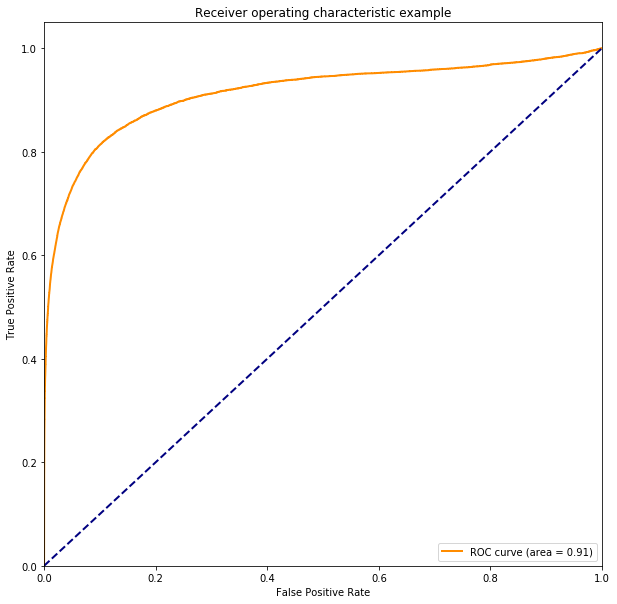

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(to_check_y, to_check_pred_raw)
roc_auc = auc(fpr,tpr)
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [34]:
# Attempt to select appropriate cutoff for prob
# Record false positive and true negative rates
fpr = []
tnr = []

for i in range(20):
    ratio = i / 20

    # custom function
    def pred_by_cutoff(x):
        return 1 if x > ratio else 0

    # define vectorized sigmoid
    pred_by_cutoff_v = np.vectorize(pred_by_cutoff)

    # test
    cm, _ = print_metrics(to_check_y, pred_by_cutoff_v(to_check_pred_raw))
    fp = cm[1][0]
    tn = cm[0][1]
    print("Normal flight accuracy:", cm[0][0] / sum(cm[0]))
    print("Ratio:", ratio, "Wrong:", fp+tn)
    fpr.append(fp)
    tnr.append(tn)

[[ 97710 159973]
 [   562  11490]]
Accuracy: 0.4048417891634382
Delay/Cancel case accuracy: 0.9533687354795884
Normal flight accuracy: 0.37918683033028955
Ratio: 0.0 Wrong: 160535
[[218466  39217]
 [  1758  10294]]
Accuracy: 0.8480916455039205
Delay/Cancel case accuracy: 0.8541320942582145
Normal flight accuracy: 0.847809129822301
Ratio: 0.05 Wrong: 40975
[[238341  19342]
 [  2659   9393]]
Accuracy: 0.9184347600422637
Delay/Cancel case accuracy: 0.7793727182210421
Normal flight accuracy: 0.9249387813709092
Ratio: 0.1 Wrong: 22001
[[246188  11495]
 [  3423   8629]]
Accuracy: 0.9446938662020131
Delay/Cancel case accuracy: 0.7159807500829738
Normal flight accuracy: 0.9553909260603144
Ratio: 0.15 Wrong: 14918
[[250279   7404]
 [  4074   7978]]
Accuracy: 0.9574471240291397
Delay/Cancel case accuracy: 0.661964819117159
Normal flight accuracy: 0.971267021883477
Ratio: 0.2 Wrong: 11478
[[252663   5020]
 [  4678   7374]]
Accuracy: 0.9640461934861995
Delay/Cancel case accuracy: 0.611848655824759

<Figure size 432x288 with 0 Axes>

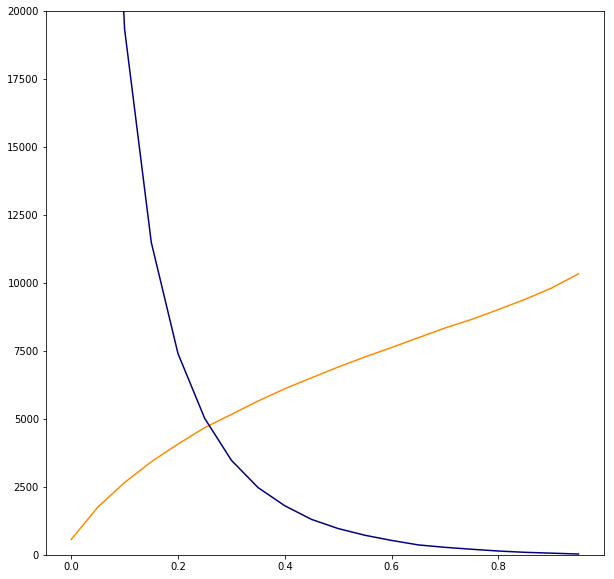

In [35]:
prob_bins = [i / 20 for i in range(20)]
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(prob_bins, fpr, color='darkorange')
plt.plot(prob_bins, tnr, color='navy')
plt.ylim([0, 20000])
plt.show()

In [25]:
np.histogram(to_check_pred_raw, bins=np.arange(0,1,0.1))

(array([137190,    284,    276,    319,    334,    336,    313,    359,
           463], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

In [23]:
prob_df = pd.DataFrame({'predicted_value': to_check_pred_raw, 'true_value': to_check_y})

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

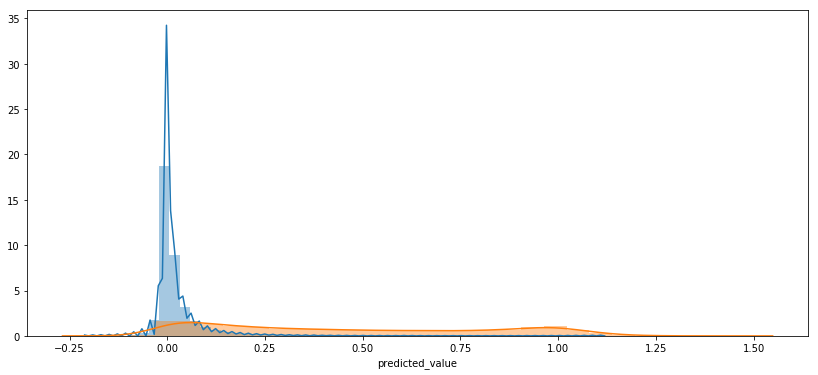

In [28]:
import seaborn as sns
plt.figure()
plt.figure(figsize=(14,6))
sns.distplot(prob_df[prob_df['true_value'] == 0]['predicted_value'])
sns.distplot(prob_df[prob_df['true_value'] == 1]['predicted_value'])

In [29]:
pd.DataFrame({'feature': all_feats, 
              'Importance by split': model.feature_importance(importance_type='split'), 
              'Importance by gain': model.feature_importance(importance_type='gain')}).sort_values('Importance by gain', ascending=False)

,feature,Importance by split,Importance by gain
0,flight_no,21380,22891.953481
1,Week,19583,8759.791332
65,arr_air_wk_cancel_count,3017,6468.266509
25,arr_air_wk_delay_time,7188,5610.087246
12,arr_2_hr_delay_time,7260,5059.441101
24,arr_air_day_delay_time,10786,4647.499266
6,dep_hr_delay_time,10853,4532.576228
14,arr_day_delay_time,11397,3533.761938
11,arr_hr_delay_time,6569,3457.114378
8,dep_4_hr_delay_time,9633,3271.217837


In [30]:
pd.DataFrame({'feature': all_feats, 
              'Importance by split': model.feature_importance(importance_type='split'), 
              'Importance by gain': model.feature_importance(importance_type='gain')}).sort_values('Importance by split', ascending=False)

,feature,Importance by split,Importance by gain
0,flight_no,21380,22891.953481
1,Week,19583,8759.791332
14,arr_day_delay_time,11397,3533.761938
6,dep_hr_delay_time,10853,4532.576228
24,arr_air_day_delay_time,10786,4647.499266
8,dep_4_hr_delay_time,9633,3271.217837
7,dep_2_hr_delay_time,9477,3012.744810
19,air_day_delay_time,9119,2211.272098
13,arr_4_hr_delay_time,8795,3094.264575
18,air_4_hr_delay_time,8638,2557.284150


In [158]:
# Get x/y columns
x_all = data_df
y_all = data_df['is_claim']

# Split training/testing set
train, test, y_train, y_test = train_test_split(x_all, y_all,
                                                random_state=10, test_size=0.3)
train = train[all_feats]
test = test[all_feats]

In [159]:
# For gradient boosting, lightGBM is used
# The parameters are fixed in this stage
lg = lgb.LGBMRegressor(silent=False)
d_train = lgb.Dataset(train, label=y_train)
params = {
    "max_depth": 50,
    "learning_rate" : 0.1, 
    #"num_leaves": 1200,
    "num_leaves": 900, 
    #"num_leaves": 300,
    #"num_leaves": 3000,
    "n_estimators": 300
}

# Train model with catgeorical features
model = lgb.train(params, d_train, categorical_feature = cat_feats)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['Airline', 'Arrival', 'Departure', 'Week', 'flight_no', 'std_hour']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [160]:
# Training set metrics
to_check_train, to_check_y = train, y_train
to_check_pred = model.predict(to_check_train).round()

In [161]:
# Q1 error
sum(abs(to_check_pred - to_check_y)) / len(to_check_y)

19.05464751763246

In [162]:
# Q2 error
sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y)

2536.8779749562664

In [163]:
# Testing set metrics
to_check_train, to_check_y = test, y_test
to_check_pred = abs(model.predict(to_check_train).round())

In [164]:
# Q1 error
sum(abs(to_check_pred - to_check_y)) / len(to_check_y)

44.96248910968173

In [165]:
# Q2 error
sum(abs(to_check_pred - to_check_y) ** 2) / len(to_check_y)

15491.212349157506

In [ ]:
# Try again with 10-fold
for i in range(10):
    train, test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3)
    
    lg = lgb.LGBMClassifier(silent=False)
    d_train = lgb.Dataset(train, label=y_train)
    params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}
    model = lgb.train(params, d_train, categorical_feature = cat_feats)
    
    print("Round ", i, "---------------------")
    # Testing set metrics
    to_check_train, to_check_y = test, y_test
    to_check_pred = model.predict(to_check_train).round()
    print_metrics(to_check_y, to_check_pred)